In [1]:
import torch
from torch.nn import Module
from torch.utils import data
import os
import torchvision.transforms as transforms
import gzip
import numpy as np
from PIL import Image
from tqdm import tqdm
import codecs
%matplotlib inline
import matplotlib.pyplot as plt

Load data

In [2]:
class MNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return os.path.exists(os.path.join(self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.processed_folder, self.test_file))

    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, \
                gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.raw_folder, filename)
            download_url(url, root=self.raw_folder, filename=filename, md5=None)
            self.extract_gzip(gzip_path=file_path, remove_finished=True)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


root = './data'
if not os.path.exists(root):
    os.mkdir(root)

# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
# from torchvision.datasets.utils import download_url, makedir_exist_ok

import errno
def makedir_exist_ok(dirpath):
    """
    Python2 support for os.makedirs(.., exist_ok=True)
    """
    try:
        os.makedirs(dirpath)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
            
def download_url(url, root, filename, md5):
    from six.moves import urllib

    root = os.path.expanduser(root)
    fpath = os.path.join(root, filename)

    makedir_exist_ok(root)

    # downloads file
    if os.path.isfile(fpath) and check_integrity(fpath, md5):
        print('Using downloaded and verified file: ' + fpath)
    else:
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(
                url, fpath,
                reporthook=gen_bar_updater(tqdm(unit='B', unit_scale=True))
            )
        except OSError:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(
                    url, fpath,
                    reporthook=gen_bar_updater(tqdm(unit='B', unit_scale=True))
                )
def gen_bar_updater(pbar):
    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update
def check_integrity(fpath, md5=None):
    if md5 is None:
        return True
    if not os.path.isfile(fpath):
        return False
    md5o = hashlib.md5()
    with open(fpath, 'rb') as f:
        # read in 1MB chunks
        for chunk in iter(lambda: f.read(1024 * 1024), b''):
            md5o.update(chunk)
    md5c = md5o.hexdigest()
    if md5c != md5:
        return False
    return True

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return torch.from_numpy(parsed).view(length).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)
    
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

train_set = MNIST(root=root, train=True, transform=trans, download=True)
test_set = MNIST(root=root, train=False, transform=trans, download=True)

### script file

# Parameters for training on GPU 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# params = {'batch_size': 64,
#          'shuffle': True,
#          'num_workers': 6}
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                dataset=train_set,
                batch_size=batch_size,
                shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print ('==>>> total trainning batch number: {}'.format(len(train_loader)))
print ('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 600
==>>> total testing batch number: 100


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifer = nn.Sequential(
            nn.Linear(128*4*4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10))
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.classifer(x)
        return x
    
    def name(self):
        return "LeNet"
    # returns activation values for a specific input x
#     def eval_act_features(self, x):
#         activations = []
#         for idx in range(len(self.features)):
#             features[idx]
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
iters = 10

In [6]:
model = LeNet()
if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# from __future__ import division
for epoch in range(iters):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
#         x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))
    # testing
    correct_cnt, ave_loss = 0.0, 0.0
    total_cnt = 0.0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
#         x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
#         print(type(total_cnt))
#         print(correct_cnt.shape)
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
#         correct_cnt = correct_cnt.to(dtype=torch.float)
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            acc = float(correct_cnt * 1.0) / float(total_cnt)
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, acc))

torch.save(model.state_dict(), model.name())

==>>> epoch: 0, batch index: 100, train loss: 1.107905
==>>> epoch: 0, batch index: 200, train loss: 0.297107
==>>> epoch: 0, batch index: 300, train loss: 0.163386
==>>> epoch: 0, batch index: 400, train loss: 0.157907
==>>> epoch: 0, batch index: 500, train loss: 0.150595
==>>> epoch: 0, batch index: 600, train loss: 0.089652
==>>> epoch: 0, batch index: 100, test loss: 0.083989, acc: 0.972
==>>> epoch: 1, batch index: 100, train loss: 0.084506
==>>> epoch: 1, batch index: 200, train loss: 0.099376
==>>> epoch: 1, batch index: 300, train loss: 0.087921
==>>> epoch: 1, batch index: 400, train loss: 0.076241
==>>> epoch: 1, batch index: 500, train loss: 0.057023
==>>> epoch: 1, batch index: 600, train loss: 0.065243
==>>> epoch: 1, batch index: 100, test loss: 0.061061, acc: 0.978
==>>> epoch: 2, batch index: 100, train loss: 0.053431
==>>> epoch: 2, batch index: 200, train loss: 0.054164
==>>> epoch: 2, batch index: 300, train loss: 0.059244
==>>> epoch: 2, batch index: 400, train los

In [11]:
import foolbox

# create foolbox model
fmodel = foolbox.models.PyTorchModel(model.eval(), bounds=(0, 1), num_classes=10)

test_loader2 = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=10000,
                shuffle=False)

for batch_idx, (x, target) in enumerate(test_loader2):
    x, target = x, target

np_x = x.numpy()

target_np = target.numpy()

attack = foolbox.attacks.FGSM(fmodel)

In [35]:
image_idx = 400

print(fmodel.predictions(np_x[image_idx]))

print("normal classification:", np.argmax(fmodel.predictions(np_x[image_idx])))

adv = attack(np_x[image_idx], int(target[image_idx]),epsilons=[epsilon])

print(fmodel.predictions(adv))
print("adv classification", np.argmax(fmodel.predictions(adv)))

[ 3.5344129  -2.3880734  13.048282    0.98991877 -0.7775176  -4.196883
 -6.4003415  -0.7726093   1.3642799  -3.156856  ]
normal classification: 2
[ 4.935063  -4.8018956  4.762754   2.0161464 -1.9008274 -2.7528062
 -5.818899  -1.5559013  3.3923798  2.2492034]
adv classification 0


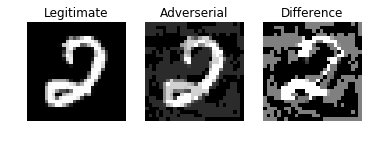

In [36]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('Legitimate')
plt.imshow(np.reshape(np_x[image_idx],[28,28]), interpolation="nearest", cmap="gray")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Adverserial')
plt.imshow(np.reshape(adv,[28,28]), interpolation="nearest", cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
diff = np.reshape(np_x[image_idx],[28,28]) - np.reshape(adv,[28,28])
plt.imshow(diff/abs(diff).max() * 0.2 + 0.5, interpolation="nearest", cmap="gray")
plt.axis('off')
# plt.show()
plt.savefig('adv_diff.png',bbox_inches='tight')

In [34]:
epsilon = 0.17
trial_eps = np.linspace(0.15, 0.5)
# it takes a long time to run this cell 
adv_errors = 0
classification_rates = []

for ep in trial_eps:
    
    for i in range(1000):
        image = np_x[i]
        label = target_np[i]
    #     print('normal class:', np.argmax(fmodel.predictions(image)), label)
        adv = attack(image, int(label))
        pred = np.argmax(fmodel.predictions(image))
        if adv is not None:
            adv_pred = np.argmax(fmodel.predictions(adv))
            if pred != adv_pred:
                adv_errors = adv_errors + 1
    acc = (1-(adv_errors/1000))
    classification_rates.append(acc)
    print("For ep: {:.2f}, classification rate: {:.3f}".format(
                ep, acc))

In [ ]:
len(classification_ra)